In [17]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

In [18]:
results = pd.read_json("results/aucs.json")

In [19]:
results_show = results.round(3)
results_show["mean"] = results_show.mean(axis=1).round(3)
results_show

,nyc_taxi,ec2_request_latency_system_failure,msl,swat,smap,smd,mean
aelstm,0.716,0.998,0.612,0.840,0.618,0.828,0.769
anotrans,0.491,0.994,0.553,0.819,0.621,0.678,0.693
usad,0.669,0.977,0.684,0.255,0.547,0.605,0.623
lstm,0.511,0.999,0.595,0.842,0.604,0.833,0.731
tranad,0.551,0.967,0.644,0.815,0.581,0.884,0.740
patchtrad,0.922,0.999,0.661,0.845,0.660,0.869,0.826
patchad,0.972,0.998,0.622,0.822,0.671,0.818,0.817
madgan,0.782,0.011,0.460,0.791,0.568,0.708,0.553
drocc,0.529,0.886,0.593,0.751,0.705,0.638,0.684
lstm_rev,0.646,0.998,0.627,0.238,0.586,0.858,0.659


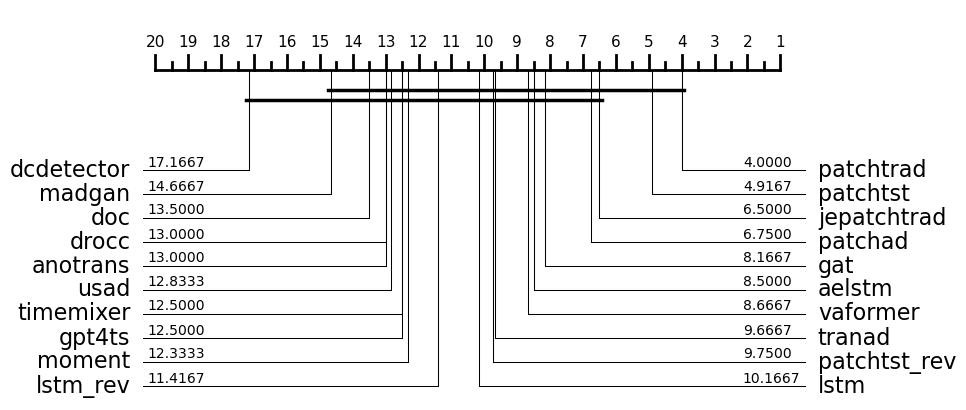

In [20]:
results.drop(['catch'], axis=0, inplace=True)
results = results.T
methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi')  

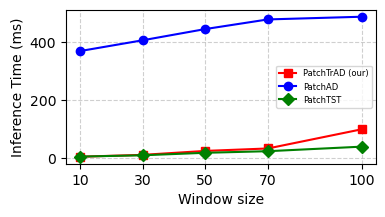

In [12]:
# Inference Speed for PatchAD, PatchTrAD, TranAD on the SWaT Dataset

import time
import torch
import matplotlib.pyplot as plt
import numpy as np

from models.patchad import PatchADLit
from models.patchtrad import PatchTradLit
from models.patchtst import PatchTSTLit
#from models.catch import CATCHModel

import yaml
from types import SimpleNamespace

DEVICE="cuda"

wss = [10, 30, 50, 70, 100]
inference_times = {model: [] for model in ['PatchAD', 'PatchTrAD', 'PatchTST']}
for ws in wss:

    patchad_conf = yaml.safe_load(open("conf/dataset_model/patchad/swat.yaml"))
    patchad_conf["ws"]=ws-1
    patchad_conf["len_loader"] = 20
    patchad = PatchADLit(SimpleNamespace(**patchad_conf))
    patchtrad_conf = yaml.safe_load(open("conf/dataset_model/patchtrad/swat.yaml"))
    patchtrad_conf["ws"]=ws-1
    patchtrad_conf["len_loader"] = 20
    patchtrad = PatchTradLit(SimpleNamespace(**patchtrad_conf))
    patchtst_conf = yaml.safe_load(open("conf/dataset_model/patchtst/swat.yaml"))
    patchtst_conf["ws"]=ws-1
    patchtst_conf["len_loader"] = 20
    patchtst = PatchTSTLit(SimpleNamespace(**patchtst_conf))
    #catch_conf = yaml.safe_load(open("conf/dataset_model/catch/swat.yaml"))
    #catch_conf["ws"]=ws-1
    #catch = CATCHModel(SimpleNamespace(**catch_conf))


    x = torch.randn(128, ws, 51)

    models = {
        "PatchAD": patchad,
        "PatchTrAD": patchtrad,
        "PatchTST": patchtst
        }

    def measure_inference_speed(model, x, device="cuda", runs=50):
        x = x.to(device)
        model = model.to(device)
        model.eval()
        # Warm-up
        with torch.no_grad():
            for _ in range(10):
                _ = model.get_loss(x, mode="test")
        
        # Measure inference time
        times = []
        with torch.no_grad():
            for _ in range(runs):
                start = time.time()
                _ = model.get_loss(x, mode="test")
                end = time.time()
                times.append(end - start)
    
        avg_time = np.mean(times) * 1000  
        model = model.cpu()
        return avg_time

    
    for name, model in models.items():
        inference_times[name].append(measure_inference_speed(model, x))

inference_times = {k: v for k, v in zip(['PatchTrAD', 'PatchAD', 'PatchTST'], [inference_times['PatchTrAD'], inference_times['PatchAD'], inference_times['PatchTST']])}

col = {
    "PatchAD": "blue",
    "PatchTrAD": "red",
    "PatchTST": "green",
}
markers = {
    "PatchAD": "o",
    "PatchTrAD": "s",
    "PatchTST": "D",
}

plt.figure(figsize=(4, 2))

for name, values in inference_times.items():
    # different color and linestyle for each model
    plt.plot(wss, values, label=name+" (our)" if name=="PatchTrAD" else name, color=col[name], linestyle='-', marker=markers[name])
# patchtrad above in legend
plt.legend(fontsize=6)
plt.xticks(wss) 
plt.xlabel("Window size")
plt.ylabel("Inference Time (ms)")
#plt.title("Inference Speed Comparison based on SWaT Dataset configuration for multiple window size")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("infspeed.png", bbox_inches="tight")

In [11]:
plt.savefig("infspeed.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>